# Parallel Computing

Parallel computing is a programming method that **harnesses the power of multiple processors (or cores) at once**. Once of concern only to programmers of large supercomputers, modern computers now almost always have multi-core processors.

### How many CPU cores do I have?

In [2]:
using Hwloc
Hwloc.num_physical_cores()

4

In [3]:
Sys.CPU_THREADS

4

(Note that `Sys.CPU_THREADS` may or may not be equal to the number above. It indicates the number of CPUs + Hyperthreads.)

### Why go parallel?

<img src="42-years-processor-trend.svg" width=700px>

### **Amdahl's Law**

Naive expectation: I have 4 cores, give me my 4x speedup!

>If $p$ is the fraction of a code that can be parallelized than the maximal theoretical speedup by parallelizing on $n$ cores is given by $F(n) = 1/(1-p + p/n)$.

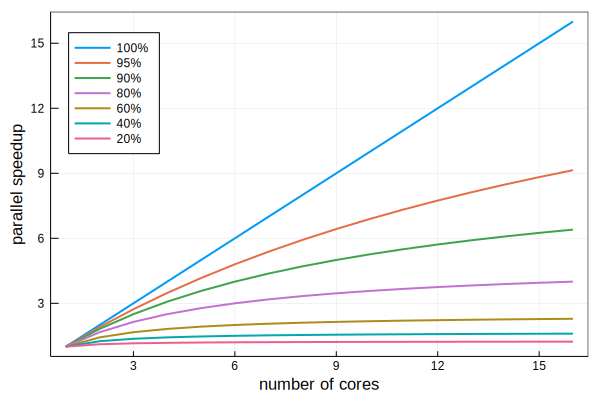

In [4]:
using Plots
F(p,n) = 1/(1-p + p/n)

pl = plot()
for p in reverse(sort(vcat(0.2:0.2:1, [0.9, 0.95])))
    plot!(pl, n -> F(p,n), 1:16, lab="$(Int(p*100))%", lw=2,
        legend=:topleft, xlab="number of cores", ylab="parallel speedup", frame=:box)
end
pl

# Parallel Computing in Julia

Julia documentation link: [Parallel computing](https://docs.julialang.org/en/v1/manual/parallel-computing/index.html)

There are many types of parallelism, some of which are (from micro to macro)

* **Instruction level parallelism**
* **Multi-threading** (process shared memory)
* **Tasks aka Coroutines** aka Green threads (more like cooperative multitasking, process shared memory)
* **Multi-Core processing** (maybe system shared memory)
* **Distributed processing** (same as above but involving multiple machines)

Julia provides (more or less) native support for all of these forms of parallel processing (same order as above)

* `@simd` and [SIMD.jl](https://github.com/eschnett/SIMD.jl)
* `Base.Threads.@threads` (experimental since 2015 but seems to be fine)
* `@async`, `@sync`, `Channel`
* `@spawnat`, `@fetch`, `RemoteChannel`, `SharedArray`, etc.
* `@spawnat`, `@fetch`, `RemoteChannel`, `DArray`, `MPI.jl` etc.

With scientific computing in mind, we will mainly focus on how to distribute a process through multiple cores or machines (our thp cluster for example), that is **Multi-Core processing** and **Distributed processing**. But before we can do so, we have to learn how to control Julia's control flow through tasks.

# Tasks (Control flow)

By default, Julia waits for every command to finish and run everything sequentially.

Tasks are a control flow feature that allows computations to be **suspended** and resumed in a flexible manner. This feature is sometimes called by other names, such as coroutines, green or lightweight threads and cooperative multitasking.

To me, the name **cooperative multitasking** is the most descriptive. Tasks are managed/scheduled by Julia and can sometimes be run in a quasi-parallel fashion.

An important use case is **asynchronous I/O**, which is typically slow. Examples are
 * **multiple user input** (Why not already process some of the input?)
 * **data dumping to disk** (Maybe it's possible to continue a calculation?)
 * **receiving calculations from worker processes** (We'll need that below!)

How do we execute commands asynchronously?

## `@async` and `@sync`

(Based on [this](https://stackoverflow.com/questions/37287020/how-and-when-to-use-async-and-sync-in-julia/37287021#37287021) stackoverflow answer.)

In [5]:
?@async

```
@async
```

Wrap an expression in a [`Task`](@ref) and add it to the local machine's scheduler queue.


What this means is that for whatever falls within its scope, Julia will start a task to then proceed to whatever comes next in the script **without waiting for the task to complete**.

In [6]:
@time sleep(2);

  2.031998 seconds (82.55 k allocations: 4.324 MiB)


In [7]:
@time @async sleep(2)

  0.006419 seconds (6.72 k allocations: 385.456 KiB)


Task (runnable) @0x00000000341dc2f0

Julia allows the script to proceed (and the `@time` macro to fully execute) without waiting for the task (in this case, sleeping for two seconds) to complete.

We can use the `@sync` macro to synchronize, that is wait for, all encapsulated tasks. (see `?@sync`). 

In [8]:
@time @sync @async sleep(2)

  2.031486 seconds (16.52 k allocations: 782.446 KiB)


Task (done) @0x000000002f3bc2f0

Of course, here it doesn't make much sense to write `@sync @async` - we could simply drop it altogether.

A better example is the following.

In [9]:
@time @sync begin
    @async sleep(2.0)
    @async sleep(2.0)
end

  2.028964 seconds (13.29 k allocations: 732.489 KiB)


Task (done) @0x000000002f3bdcd0

In [10]:
@sync begin
    @async (sleep(2); println("Today is reverse day!"))
    @async (sleep(1); println(" class!"))
    @async print("Hello")
end;

Hello class!
Today is reverse day!


# Distributed processing: Multi-core

Distributed computing in Julia means having **multiple separate Julia instances running on different cores** on the same or different machines.

Data movement and communication between processes is explicit.

Let's focus on the *multi-core* case (your laptop/desktop) and save some cluster fun for later.

## Master-worker model

Julia uses a *master-worker* paradigm for its native distributed parallelism.

One master process coordinates all the worker processes, which perform the actual computations.

By default, Julia starts with one process on one core. If this single process is all we have, than it is both the master and the worker.

In [11]:
using Distributed # Loading all tools that we need for distributed computing

In [12]:
nprocs()

1

In [13]:
nworkers() # the master is considered a worker as long as there are no real workers

1

To increase the number of workers, i.e. Julia processes, from within a Julia session we can use `addprocs`.

Alternatively, when starting Julia from the command line, one can use the `-p` option. Example,

```
julia -p 4
```

will start Julia with 5 processes, 1 master and 4 workers.

In [14]:
addprocs(4) # I have 4 cores, so let's add 4 worker processes.

4-element Array{Int64,1}:
 2
 3
 4
 5

Every process has a Julia internal `pid` (process id). The master is always 1. You can get the workers pids from `workers()`.

In [15]:
workers()

4-element Array{Int64,1}:
 2
 3
 4
 5

Note that the 4 worker's pids aren't necessarily 2, 3, 4 and 5. Let's remove the processes and add them once more.

In [16]:
rmprocs(workers()) # rmprocs(array of pids of worker processes to remove)

Task (done) @0x000000002f8f2b30

In [17]:
nworkers() # only the master is left

1

In [18]:
addprocs(4)

4-element Array{Int64,1}:
 6
 7
 8
 9

In [19]:
workers()

4-element Array{Int64,1}:
 6
 7
 8
 9

## One master to rule them all - `@spawn`, `@spawnat`, `@fetch`, `@fetchfrom`, `@everywhere`...

To execute commands and start computations on workers we can use the following macros

* `@spawn`: run a command or a code block on any worker and return a `Future` to it's result. It's basically a version of `@async` for remote processes.
* `@spawnat`: same as `@spawn` but one can choose a specific worker by providing its pid.

**Example:** Let's say we would like to generate a random matrix on one of the workers.

In [20]:
@spawn rand(2,2) # basically @async for remote process, i.e. returns immediately

Future(6, 1, 10, nothing)

In [21]:
result = @spawn rand(2,2)

Future(7, 1, 11, nothing)

In [22]:
fetch(result) # blocks, like @sync

2×2 Array{Float64,2}:
 0.809299  0.509393
 0.852996  0.512583

Because the combination of spawning at fetching is so common, there is `@fetch` which combines them.

In [23]:
@fetch rand(2,2)

2×2 Array{Float64,2}:
 0.8263    0.864689
 0.732377  0.100403

Which worker did the work?

In [30]:
@fetch begin
    println(myid());
    rand(2,2)
end

      From worker 7:	7


2×2 Array{Float64,2}:
 0.229717  0.759929
 0.14889   0.752025

Using `@spawnat` and `@fetchfrom` we can delegate the work to a specific worker.

In [44]:
@fetchfrom workers()[3] begin
    println(myid());
    rand(2,2)
end

      From worker 8:	8


2×2 Array{Float64,2}:
 0.261581  0.784215
 0.462334  0.938527

We can use `@sync` as a blocker to wait for all workers to complete their tasks.

In [45]:
@sync begin
    pids = workers()
    @spawnat pids[1] (sleep(2); println("Today is reverse day!"))
    @spawnat pids[2] (sleep(1); println(" class!"))
    @spawnat pids[3] println("Hello")
end;
println("Done!")

      From worker 8:	Hello
      From worker 7:	 class!
      From worker 6:	Today is reverse day!
Done!


Ok, now that we understood all that, let's delegate a *complicated* calculation

In [46]:
using Random

function complicated_calculation()
    sleep(1) # so complex that it takes a long time :)
    randexp(5)
end

@fetch complicated_calculation()

RemoteException: On worker 8:
UndefVarError: #complicated_calculation not defined
deserialize_datatype at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:1186
handle_deserialize at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:775
deserialize at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:722
handle_deserialize at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:782
deserialize_global_from_main at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:722
#5 at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Distributed\src\clusterserialize.jl:72 [inlined]
foreach at .\abstractarray.jl:1920
deserialize at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Distributed\src\clusterserialize.jl:72
handle_deserialize at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:860
deserialize at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:722
handle_deserialize at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:779
deserialize at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:722
handle_deserialize at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:782
deserialize_msg at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Serialization\src\Serialization.jl:722
#invokelatest#1 at .\essentials.jl:790 [inlined]
invokelatest at .\essentials.jl:789 [inlined]
message_handler_loop at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Distributed\src\process_messages.jl:183
process_tcp_streams at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.2\Distributed\src\process_messages.jl:140
#105 at .\task.jl:268

What happened?

**Think of every worker as a separate Julia instance.**

We only defined `complicated_calculation()` on the master process. The function doesn't exist on any of the workers yet.

The macro `@everywhere` comes for the rescue.

In [47]:
@everywhere begin # execute this block on all workers
    using Random
    
    function complicated_calculation()
        sleep(1)
        randexp(5) # lives in Random
    end
end

In [48]:
@fetch complicated_calculation()

5-element Array{Float64,1}:
 0.9722616638822857
 2.420641109202318 
 2.1362605354866755
 0.1815570007654114
 1.0104508793550906

## Data movement

There is a crucial difference between the following two pieces of code. Can you guess what it is?

In [49]:
function method1()
    A = rand(100,100)
    B = rand(100,100)
    C = @fetch A^2 * B^2
end

method1 (generic function with 1 method)

In [50]:
function method2()
    C = @fetch rand(100,100)^2 * rand(100,100)^2
end

method2 (generic function with 1 method)

Let's benchmark them.

In [52]:
using BenchmarkTools
@btime method1();
@btime method2();

  435.900 μs (133 allocations: 239.00 KiB)
  349.800 μs (103 allocations: 82.02 KiB)


Method 1 is slower, because `A` and `B` are created on the master process, transferred to a worker, and squared and multiplied on the worker process before the result is finally transferred back to the master.

Method 2, on the other hand, creates, squares, and multiplies the random matrix all on the work process and only submits the result to the master.

Hence, `method1` is **transferring 3x as much data** between the master and the worker!

**Data movement is crucial!**

In this toy example, it's rather easy to identify the faster method.

In a real program, however, understanding data movement does require more thought and likely some measurement.

For example, if the first process needs matrix `A` in a follow-up computation then the first method might be better in this case. Or, if computing `A` is expensive and only the current process has it, then moving it to another process might be unavoidable.

#### Computer latency at a human scale

To understand why thinking about data is important it's instructive to look at the time scales involved in data access.

<img src="latency_human_scales.png" width=900px>

(taken from https://www.prowesscorp.com/computer-latency-at-a-human-scale/)

### Avoid globals (once more)

In [53]:
myglobal = 4

4

In [30]:
function whohas(s::String)
    @everywhere begin
        var = Symbol($s)
        if isdefined(Main, var)
            println("$var exists.")
        else
            println("Doesn't exist.")
        end
    end
    nothing
end

whohas (generic function with 1 method)

In [55]:
whohas("myglobal")

myglobal exists.
      From worker 6:	Doesn't exist.
      From worker 7:	Doesn't exist.
      From worker 8:	Doesn't exist.
      From worker 9:	Doesn't exist.


In [57]:
@fetchfrom workers()[1] myglobal+2

6

In [58]:
whohas("myglobal")

myglobal exists.
      From worker 6:	myglobal exists.
      From worker 8:	Doesn't exist.
      From worker 7:	Doesn't exist.
      From worker 9:	Doesn't exist.


Globals get copied to workers and continue to exist as globals even after the call.

This could lead to memory accumulation if many globals are used (just as it would in a single Julia session).

It's better to avoid them.

## Explicit data movement: `Channel` and `RemoteChannel`

Channels in Julia are constructs to explicitly exchange data between workers.

They implement `put!`, `take!`, `fetch`, `isready` and `wait` methods.

In [ ]:
# ?Channel

In [2]:
ch = Channel{Int}(5) # a channel that can hold up to 5 integers

Channel{Int64}(sz_max:5,sz_curr:0)

In [4]:
isready(ch) # something in the channel?

false

In [6]:
put!(ch, 3)

3

In [7]:
isready(ch)

true

In [8]:
take!(ch)

3

In [9]:
isready(ch)

false

In [10]:
put!(ch, 4)

4

In [11]:
fetch(ch) # basically take without a bang

4

In [12]:
take!(ch)

4

Be careful, `take!` and `put!` are blocking if the channel is empty or full!

In [13]:
isready(ch)

false

In [ ]:
# take!(ch) if we execute this, while isready(ch) == false, the current Julia session will hang.

## Channels for inter-process data movement: `RemoteChannel`

* A `Channel` is local to a process. Worker 2 cannot directly refer to a `Channel` on worker 3 and vice-versa.


* A `RemoteChannel`, however, can put and take values across workers. A `RemoteChannel` can be thought of as a handle to a `Channel`.


* Any process with a reference to a `RemoteChannel` can put and take items from the channel. Data is automatically sent to (or retrieved from) the process a `RemoteChannel` is associated with.


* The process id, pid, associated with a `RemoteChannel` identifies the process where the backing store, i.e., the backing Channel exists.

In [14]:
nworkers()

4

In [15]:
addprocs(4)

4-element Array{Int64,1}:
 6
 7
 8
 9

In [16]:
?RemoteChannel

search: RemoteChannel



```
RemoteChannel(pid::Integer=myid())
```

Make a reference to a `Channel{Any}(1)` on process `pid`. The default `pid` is the current process.

```
RemoteChannel(f::Function, pid::Integer=myid())
```

Create references to remote channels of a specific size and type. `f` is a function that when executed on `pid` must return an implementation of an `AbstractChannel`.

For example, `RemoteChannel(()->Channel{Int}(10), pid)`, will return a reference to a channel of type `Int` and size 10 on `pid`.

The default `pid` is the current process.


In [ ]:
sq(x) = x^2
function sq(x)
    x^2
end

In [18]:
a = x -> x^2

#5 (generic function with 1 method)

In [19]:
a(3)

9

In [20]:
x = [1,-3,4,-8,10,5]

6-element Array{Int64,1}:
  1
 -3
  4
 -8
 10
  5

In [25]:
function mystupidfunction(y)
    if iseven(y) && y<0
        return true
    else
        return false
    end
end     

mystupidfunction (generic function with 1 method)

In [ ]:
x,y -> x^2 + y^2

In [27]:
filter((y) -> iseven(y) && y<0, x)

1-element Array{Int64,1}:
 -8

In [28]:
# creates a channel on the second worker process
# create a RemoteChannel handle to this channel on the master process
const mychannel = RemoteChannel(()->Channel{Int}(10), workers()[2])

RemoteChannel{Channel{Int64}}(3, 1, 10)

In [31]:
whohas("mychannel")

mychannel exists.
      From worker 3:	Doesn't exist.
      From worker 4:	Doesn't exist.
      From worker 2:	Doesn't exist.
      From worker 6:	Doesn't exist.
      From worker 5:	Doesn't exist.
      From worker 7:	Doesn't exist.
      From worker 8:	Doesn't exist.
      From worker 9:	Doesn't exist.


In [32]:
# One could create a global constant mychannel everywhere
@everywhere const mychannel = $mychannel

In [33]:
whohas("mychannel")

mychannel exists.
      From worker 2:	mychannel exists.
      From worker 4:	mychannel exists.
      From worker 6:	mychannel exists.
      From worker 7:	mychannel exists.
      From worker 8:	mychannel exists.
      From worker 9:	mychannel exists.
      From worker 5:	mychannel exists.
      From worker 3:	mychannel exists.


However, as we said many times before, one should generally try to avoid globals. The following is preferable.

In [34]:
function do_something()
    rc = RemoteChannel(()->Channel{Int}(10)) # lives on the master
    @sync for p in workers()
        @spawnat p put!(rc, myid())
    end
    rc
end

r = do_something()

RemoteChannel{Channel{Int64}}(1, 1, 60)

In [35]:
isready(r)

true

In [36]:
while isready(r)
    @show take!(r)
end

take!(r) = 3
take!(r) = 7
take!(r) = 5
take!(r) = 6
take!(r) = 4
take!(r) = 2
take!(r) = 8
take!(r) = 9


The ecosystem also contains a couple of tools, that make data transfer even simpler. See for example [ParallelDataTransfer.jl](https://github.com/ChrisRackauckas/ParallelDataTransfer.jl/).

# Parallelizing the easy way - `@distributed` and `pmap`

So far we have seen the build block of commands for distributed computing in Julia. Having scientific computing in mind, one might not always want to think about how to distribute the work and explicitly spawn tasks.

Also, fortunately, many useful parallel computations do not require (much) data movement. A common example is a direct Monte Carlo simulation, where multiple processes can handle independent simulation trials simultaneously. (We'll get to that later!)

Julia provides convenience macros to
 * Parallelize loops (`@distributed`)
 * Apply a function to all elements in some collection (`pmap`)
 
Let's explore these!

## Distributed loops (`@distributed`)

In [37]:
using Distributed, BenchmarkTools; rmprocs(workers()); addprocs(4); nworkers()

4

In [38]:
# serial version - count heads in a series of coin tosses
function add_serial(n)
    c = 0
    for i = 1:n
        c += rand(Bool)
    end
    c
end

@btime add_serial(200_000_000);

  270.357 ms (0 allocations: 0 bytes)


This is trivially parallelizable since the loop iterations are independent of each other. We can distribute coin tosses over a couple of workers.

Afterwards we combine the results, that is we sum them up. The combination process is generally called a *reduction*, and in this case `sum` is the *reducer function*.

To distribute the for loop over worker processes Julia provides the `@distributed` macro:

In [ ]:
?@distributed

In [40]:
# distributed version
function add_distributed(n)
    c = @distributed (+) for i in 1:n
        Int(rand(Bool))
    end
    c
end

@btime add_distributed(200_000_000);

  72.263 ms (448 allocations: 18.30 KiB)


The distributed version is about **4x faster**, which is all we could hope for.

Let's see who is doing the work

In [41]:
# verbose distributed version
function add_distributed(n)
    c = @distributed (+) for i in 1:n
        x = Int(rand(Bool))
        println(x);
        x
    end
    c
end

add_distributed(8);

      From worker 12:	1
      From worker 10:	0
      From worker 11:	1
      From worker 13:	0
      From worker 12:	0
      From worker 10:	0
      From worker 11:	1
      From worker 13:	0


Apparently, the work is evenly distributed between the workers. By using `@distributed` we let Julia decide how to split up the work and can't control it ourselves.

A common mistake when using `@distributed` is the following:

In [50]:
function f(n)
    a = 0
    @distributed (+) for i in 1:n
        a += 1
    end
    a
end

a = f(10);

What do you expect the value of `a` to be?

In [51]:
a

18

We can (sort of) see what's happening by making everything global

In [44]:
a = 0
@distributed (+) for i in 1:10
    println("1")
    global a += 1
end;

      From worker 11:	1
      From worker 12:	1
      From worker 13:	1
      From worker 10:	1
      From worker 11:	1
      From worker 11:	1
      From worker 12:	1
      From worker 13:	1
      From worker 10:	1
      From worker 10:	1


In [46]:
@everywhere @show a

a = 0
      From worker 11:	a = 3
      From worker 12:	a = 2
      From worker 13:	a = 2
      From worker 10:	a = 3


The variable `a` gets copied to the worker processes as it is referenced in the distributed loop. 

Every worker will then increment its copy of `a`.

However, we do not save the result of the reduction (sum) but instead return `a` from the master process, which hasn't been altered at all.

Corrected version:

In [52]:
function f2(n)
    a = @distributed (+) for i in 1:n
        1
    end
    a
end

a = f2(10)

10

### What if I don't want to reduce?

Similar to the mistake above, the following example might not have the effect one expects. **Why?**

In [60]:
a = zeros(10)
@distributed for i = 1:10
    a[i] = i
end

Task (runnable) @0x0000000010069cd0

In [54]:
@everywhere @show a

a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      From worker 12:	a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 8.0, 0.0, 0.0]
      From worker 10:	a = [1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      From worker 11:	a = [0.0, 0.0, 0.0, 4.0, 5.0, 6.0, 0.0, 0.0, 0.0, 0.0]
      From worker 13:	a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 10.0]


Note that `@distributed` without a reduction function returns a `Task`. It is basically a distributed version of `@spawn` for all the iterations.

## `SharedArray`s

To actually make all processes operate on the same array, one can use a `SharedArray`.

Note that a `SharedArray` only works if the **processes live on the same host**.

The constructor of a SharedArray is

```julia
SharedArray{T,N}(dims::NTuple; init=false, pids=Int[])
```

which creates an `N`-dimensional shared array of a (bits) type `T` and size `dims` across the processes specified by `pids`.

(If an `init` function, of signature `initfn(S::SharedArray)`, is specified, it is called on all the participating workers. You can specify that each worker runs the init function on a distinct portion of the array, thereby parallelizing initialization.)

In [55]:
@everywhere using SharedArrays # must be loaded everywhere

In [56]:
A = rand(2,3)

2×3 Array{Float64,2}:
 0.0751331  0.530742  0.112325
 0.410691   0.145509  0.579472

In [57]:
S = SharedArray(A)

2×3 SharedArray{Float64,2}:
 0.0751331  0.530742  0.112325
 0.410691   0.145509  0.579472

Ok, now that we know how to create and fill our `SharedArray` we can create a parallel fill function:

In [58]:
function fill_shared_problematic(N)
    S = SharedMatrix{Float64}(N,N)
    @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

fill_shared_problematic(3)

3×3 SharedArray{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

*Why is the method in its current form problematic? Try to find out yourself by going to larger `N` and, for example, inspecting the minimum of the returned `SharedArray`!*

Going to larger matrix sizes....

In [61]:
function fill_shared_problematic(N)
    S = SharedMatrix{Int64}(N,N)
    @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

S = fill_shared_problematic(100)
minimum(S)

0

Note how sometimes the array isn't completely filled but still contains zeros. This is because it isn't filled **yet**!

Check again!

In [62]:
minimum(S)

1

We can use `@sync` to synchronize our distributed for loop.

In [70]:
function fill_shared_problematic(N)
    S = SharedMatrix{Int64}(N,N)
    @sync @distributed for i in 1:length(S) # added @sync here
        S[i] = i
    end
    S
end

S = fill_shared_problematic(100)
minimum(S)

1

Ok, let's **benchmark** this for a larger matrix size

In [71]:
# regular array
function fill_regular(N)
    A = Matrix{Int64}(undef,N,N)
    for i in 1:length(A)
        A[i] = i
    end
    A
end

@time fill_regular(10000);

  0.258869 seconds (20.86 k allocations: 764.072 MiB, 5.42% gc time)


In [74]:
# shared array
function fill_shared(N)
    S = SharedMatrix{Int64}(N,N)
    @sync @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

@time fill_shared(10000);

  0.255586 seconds (191.97 k allocations: 9.586 MiB)


This is of course just filling an array.

If there were actual calculations it might actually be beneficial to distribute the work across workers.

## Parallel map: `pmap`

Sometimes we merely wish to apply a function to all all elements in a collection.

For those cases, Julia provides the `pmap` (parallel map) function.

Say, we want to compute the singular values of a bunch of larger matrices in parallel.

In [76]:
@everywhere using LinearAlgebra

M = Matrix{Float64}[rand(1000,1000) for i = 1:10]

10-element Array{Array{Float64,2},1}:
 [0.5330925950927525 0.6901189743520653 … 0.7892543150052973 0.6841751486550747; 0.4006644198286762 0.9343877065522908 … 0.4602352141833119 0.4414737764315051; … ; 0.6904968370508369 0.37327712892225606 … 0.4431469268937638 0.27905227649485354; 0.014027285794929067 0.6055754078740119 … 0.43739563064086373 0.6853907116820122]     
 [0.031048476648960044 0.6268368964989524 … 0.902933201629911 0.7067020629414484; 0.6026475476055362 0.7585170488568325 … 0.23205133550139223 0.9775525822718905; … ; 0.5701607978571896 0.018943960947579663 … 0.35881276655647865 0.6077587698541034; 0.03668172939872649 0.6263960621814639 … 0.3314359044210011 0.5389375354710877]    
 [0.03236920217182493 0.9785964767206616 … 0.4716950907689621 0.054239647601908025; 0.42154078489959845 0.6983841185525226 … 0.14612089219948565 0.629129143742065; … ; 0.6352496317270575 0.7612322584853946 … 0.09797189688164054 0.11585836981635111; 0.01818281058431359 0.8547520638949575 … 0.243188

In [77]:
pmap(svdvals, M)

10-element Array{Array{Float64,1},1}:
 [500.38999979189396, 18.047114079415817, 17.968589089643107, 17.929234702276272, 17.795928015940397, 17.68625956732749, 17.658912450344424, 17.621680020117427, 17.5775461703858, 17.525758691671495  …  0.13622314203750377, 0.12183064545279992, 0.11293871705739549, 0.10556725942289458, 0.0616664621852149, 0.0493667786222552, 0.042913008282710476, 0.029279370022512366, 0.011950032697085118, 0.002202861589712284]
 [500.03705854249887, 18.257072298874576, 18.10426379181714, 17.906329365437, 17.89273345189213, 17.854281567732208, 17.773330272157242, 17.701269225382635, 17.667580657237966, 17.630105932079797  …  0.12698615318073558, 0.10881042050879301, 0.10707720616652332, 0.10162331876467341, 0.0818138710151222, 0.06312315604153264, 0.05279492542356188, 0.0385352486907368, 0.010441077166236082, 0.003296660342276354]    
 [500.21486952799467, 18.25385684395223, 18.13222403001239, 18.05784610119117, 17.93415340782225, 17.775940882884292, 17.7530035642558

In [78]:
# Check that really all of the workers participated
pmap(m->begin println(myid()); svdvals(m) end, M);

      From worker 12:	12
      From worker 13:	13
      From worker 11:	11
      From worker 10:	10
      From worker 12:	12
      From worker 13:	13
      From worker 11:	11
      From worker 10:	10
      From worker 12:	12
      From worker 13:	13


In [81]:
function svds_loop(M)
    svds = Vector{Vector{Float64}}(undef, 10)
    for (i, m) in enumerate(M)
        svds[i] = svdvals(m)
    end
    svds
end

@time svds_loop(M);
@time svdvals.(M);
@time pmap(svdvals, M);

  2.873480 seconds (15.32 k allocations: 82.859 MiB, 0.51% gc time)
  2.979710 seconds (107 allocations: 82.099 MiB, 0.29% gc time)
  2.293630 seconds (1.15 k allocations: 119.984 KiB)


### When to choose which?

Julia's pmap is designed for the case where each function call does a **large amount of work**.

In contrast, `@distributed` can handle situations where **each iteration is tiny**, perhaps only summing two numbers.

# Scaling things up: THP cluster

So far we have worked on multiple cores on a single machine, your laptop for example.

Processes can live on other machines as well! This allows us to distribute our computation across computer clusters.

In principle, the plan of action is the same as in the multi-core case. However, we have to take into account the different memory situation. In particular, **data movement is expensive** and we won't be able to use `SharedArray`s.

In [82]:
rmprocs(workers()) # fresh start

Task (done) @0x000000000fbfb6b0

## Creating workers on the cluster

Adding processes on different machines is not much harder than adding them on your local machine. In the following we will take the last example, calculating singular values of a bunch of matrices, and distribute it over multiple computers in our thp network.

In Julia, starting worker processes is handled by [ClusterManagers](https://docs.julialang.org/en/stable/manual/parallel-computing/#ClusterManagers-1).

* The default one is `LocalManager`. It is automatically used when running `addprocs(i::Integer)` and we have implicitly used it already!
* The one we are going to use for the THP cluster is `SSHManager`. It is automatically used when running `addprocs(hostnames::Array)`.

Other cluster managers for SLURM, PBS, and others are provided in [ClusterManagers.jl](https://github.com/JuliaParallel/ClusterManagers.jl).

In principle, starting processes on other computers can be done by `addprocs(["l92", "l93"])`, where `"l92"` and `"l93"` are hostnames. The only requirement is a **passwordless ssh access** to all specified hosts.

*Demonstrate in terminal from thp node*

```julia
using Distributed

addprocs(["l92", "l93"])

@everywhere println(gethostname())
```

One can also start multiple processes on different machines:
```julia
addprocs([("l92", 2), ("l93", 3)]) # starts 2 workers on l92 and 3 workers on l93

# Use :auto to start as many processes as CPUs are available
```

By default, `addprocs` expects the julia executable in the same folder as on the master computer (remember: workers are independent Julia processes). It will also try to `cd` to the same folder.

In my case this would be

In [83]:
@show pwd();
@show Sys.BINDIR;

pwd() = "C:\\Users\\carsten\\Desktop\\JuliaWorkshop19\\3_Three"
Sys.BINDIR = "C:\\Users\\carsten\\AppData\\Local\\Julia-1.2.0\\bin"


Both folders don't exist in my thp account (those are linux machines!), so I'll have to tell Julia to use different paths.

Also, as per thp cluster guidelines one **(!) must (!) run computations on other thp computer with `nice -19` priority setting**!

### Creating `nice -19` workers and specifying directories 

As you can see from `?addprocs`, `addprocs` takes a bunch of keyword arguments, two of which are of particular importance.

* `dir`: working directory of the worker process
* `exename`: path to julia executable (potentially augmented with pre-commands)

In [84]:
params = (exename=`nice -19 /home/bauer/bin/julia-1.1.1/bin/julia --project=/home/bauer/JuliaWorkshop19`, dir="/home/bauer")

(exename = `nice -19 /home/bauer/bin/julia-1.1.1/bin/julia --project=/home/bauer/JuliaWorkshop19`, dir = "/home/bauer")

In [85]:
addprocs([("l92", :auto)]; params...)

4-element Array{Int64,1}:
 14
 15
 16
 17

In [86]:
@everywhere println(gethostname())

l91
      From worker 14:	l92.thp.uni-koeln.de
      From worker 17:	l92.thp.uni-koeln.de
      From worker 15:	l92.thp.uni-koeln.de
      From worker 16:	l92.thp.uni-koeln.de


In [87]:
rmprocs(workers())

Task (done) @0x000000001006a570

Ok, let's get some resources :)

In [88]:
machines = ["l92", "l93", "l95"];

procs_per_machine = :auto; # :auto for n = # cpus

jobs = [(m,procs_per_machine) for m in machines]

3-element Array{Tuple{String,Symbol},1}:
 ("l92", :auto)
 ("l93", :auto)
 ("l95", :auto)

In [89]:
addprocs(jobs; params...)

12-element Array{Int64,1}:
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29

In [90]:
@everywhere println(gethostname())

l91
      From worker 18:	l93.thp.uni-koeln.de
      From worker 22:	l93.thp.uni-koeln.de
      From worker 23:	l93.thp.uni-koeln.de
      From worker 21:	l93.thp.uni-koeln.de
      From worker 20:	l92.thp.uni-koeln.de
      From worker 19:	l95.thp.uni-koeln.de
      From worker 27:	l92.thp.uni-koeln.de
      From worker 29:	l92.thp.uni-koeln.de
      From worker 28:	l92.thp.uni-koeln.de
      From worker 26:	l95.thp.uni-koeln.de
      From worker 24:	l95.thp.uni-koeln.de
      From worker 25:	l95.thp.uni-koeln.de


In [91]:
@everywhere using LinearAlgebra

@time x = pmap(svdvals, M);

  1.930237 seconds (1.28 k allocations: 897.016 KiB)


## Distributed arrays (`DArray`)

Github: https://github.com/JuliaParallel/DistributedArrays.jl

In a `DArray`, each process has local access to just a chunk of the data, and no two processes share the same chunk. Processes can be on different hosts.

Distributed arrays are for example useful if

* Expensive calculations should be performed in parallel on parts of the array on different hosts.
* The data doesn't fit into the local machines memory (Loading big files in parallel).

In [92]:
@everywhere using DistributedArrays, LinearAlgebra

In [93]:
nworkers()

12

In [94]:
D = distribute(M)

10-element DArray{Array{Float64,2},1,Array{Array{Float64,2},1}}:
 [0.5330925950927525 0.6901189743520653 … 0.7892543150052973 0.6841751486550747; 0.4006644198286762 0.9343877065522908 … 0.4602352141833119 0.4414737764315051; … ; 0.6904968370508369 0.37327712892225606 … 0.4431469268937638 0.27905227649485354; 0.014027285794929067 0.6055754078740119 … 0.43739563064086373 0.6853907116820122]     
 [0.031048476648960044 0.6268368964989524 … 0.902933201629911 0.7067020629414484; 0.6026475476055362 0.7585170488568325 … 0.23205133550139223 0.9775525822718905; … ; 0.5701607978571896 0.018943960947579663 … 0.35881276655647865 0.6077587698541034; 0.03668172939872649 0.6263960621814639 … 0.3314359044210011 0.5389375354710877]    
 [0.03236920217182493 0.9785964767206616 … 0.4716950907689621 0.054239647601908025; 0.42154078489959845 0.6983841185525226 … 0.14612089219948565 0.629129143742065; … ; 0.6352496317270575 0.7612322584853946 … 0.09797189688164054 0.11585836981635111; 0.01818281058431359 0.

Which workers hold parts of D?

In [95]:
procs(D)

10-element Array{Int64,1}:
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27

Which parts do they hold?

In [96]:
localpart(D) # the master doesn't hold anything

0-element Array{Array{Float64,2},1}

In [97]:
# Which parts do they hold?
for p in workers()
    display(@fetchfrom p localpart(D))
    display(@fetchfrom p DistributedArrays.localindices(D)) # DistributedArrays. necessary because of SharedArrays above
end

RemoteException: On worker 18:
TypeError: in typeassert, expected Core.SimpleVector, got String
deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:916
handle_deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:856
deserialize_fillarray! at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:1019
deserialize_array at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:1011
handle_deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:769
deserialize_typename at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:731
deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Distributed/src/clusterserialize.jl:68
handle_deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:856
deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:731
handle_deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:775
deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:731
handle_deserialize at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:778
deserialize_msg at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:731
#invokelatest#1 at ./essentials.jl:742 [inlined]
invokelatest at ./essentials.jl:741 [inlined]
message_handler_loop at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Distributed/src/process_messages.jl:160
process_tcp_streams at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Distributed/src/process_messages.jl:117
#105 at ./task.jl:259

In [ ]:
@time Msquared = map(svdvals, M);

In [ ]:
@time Dsquared = map(svdvals, D);

In [ ]:
@time Psquared = pmap(svdvals, M);

In [ ]:
Msquared ≈ Dsquared

In [ ]:
Dsquared ≈ Psquared

But remember, for small operations the data movement can (and will) exceed the benefit of parallelizing the computation!

In [ ]:
@btime map(sum, M);
@btime map(sum, D);

A demonstration of distributed arrays: [Parallel loading and processing of large files](https://www.youtube.com/watch?v=euZkvgx0fG8&t=3925s)

In [ ]:
# Stop worker processes!
rmprocs(workers())

# Exercise: Parallel Monte Carlo

Calculate the value of $\pi$ through parallel direct Monte Carlo.

A unit circle is inscribed inside a unit square with side length 2 (from -1 to 1). The area of the circle is $\pi$, the area of the square is 4, and the ratio is $\pi/4$. This means that, if you throw $N$ darts randomly at the square, approximately $M=N\pi/4$ of those darts will land inside the unit circle.

Throw darts randomly at a unit square and count how many of them ($M$) landed inside of a unit circle. Approximate $\pi \approx 4M/N$. Visualization:

In [99]:
rmprocs(workers())

Task (done) @0x000000004b120e70

      From worker 21:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DataStructures [864edb3b-99cc-5e75-8d2d-829cb0a9cfe8]
      From worker 21:	│   exception = ArgumentError: Invalid checksum in cache file /home/bauer/.julia/compiled/v1.1/DataStructures/xKiwJ.ji.
      From worker 21:	└ @ Base loading.jl:969
      From worker 23:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DataStructures [864edb3b-99cc-5e75-8d2d-829cb0a9cfe8]
      From worker 23:	│   exception = Required dependency OrderedCollections [bac558e1-5e72-5ebc-8fee-abe8a469f55d] failed to load from a cache file.
      From worker 23:	└ @ Base loading.jl:969
      From worker 22:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DataStructures [864edb3b-99cc-5e75-8d2d-829cb0a9cfe8]
      From worker 22:	│   exception = Required dependency OrderedCollections [bac558e1-5e72-5ebc-8fee-abe8a469f55d] faile

      From worker 20:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for MacroTools [1914dd2f-81c6-5fcd-8719-6d5c9610ff09]
      From worker 20:	│   exception = Required dependency Tokenize [0796e94c-ce3b-5d07-9a54-7f471281c624] failed to load from a cache file.
      From worker 20:	└ @ Base loading.jl:969
      From worker 28:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for MacroTools [1914dd2f-81c6-5fcd-8719-6d5c9610ff09]
      From worker 28:	│   exception = Required dependency Tokenize [0796e94c-ce3b-5d07-9a54-7f471281c624] failed to load from a cache file.
      From worker 28:	└ @ Base loading.jl:969
      From worker 29:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for MacroTools [1914dd2f-81c6-5fcd-8719-6d5c9610ff09]
      From worker 29:	│   exception = Required dependency Tokenize [0796e94c-ce3b-5d07-9a54-7f471281c624] failed to load from a cache file.
     

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
│   exception = Required dependency LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f] failed to load from a cache file.
└ @ Base loading.jl:969


      From worker 18:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
      From worker 18:	│   exception = Required dependency LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f] failed to load from a cache file.
      From worker 18:	└ @ Base loading.jl:969
      From worker 18:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
      From worker 18:	│   exception = Required dependency LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f] failed to load from a cache file.
      From worker 18:	└ @ Base loading.jl:969
      From worker 19:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
      From worker 19:	│   exception = Required dependency LaTeXStrings [b964fa9f-0449-5b57-a5c2-d3ea65f4040f] failed to load from a cache file.
     

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
│   exception = Required dependency ColorTypes [3da002f7-5984-5a60-b8a6-cbb66c0b333f] failed to load from a cache file.
└ @ Base loading.jl:969


      From worker 20:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
      From worker 20:	│   exception = Required dependency ColorTypes [3da002f7-5984-5a60-b8a6-cbb66c0b333f] failed to load from a cache file.
      From worker 20:	└ @ Base loading.jl:969
      From worker 20:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
      From worker 20:	│   exception = Required dependency CSTParser [00ebfdb7-1f24-5e51-bd34-a7502290713f] failed to load from a cache file.
      From worker 20:	└ @ Base loading.jl:969


┌ Warning: Replacing module `CSTParser`
└ @ Base loading.jl:878
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
│   exception = Required dependency ColorTypes [3da002f7-5984-5a60-b8a6-cbb66c0b333f] failed to load from a cache file.
└ @ Base loading.jl:969


      From worker 18:	┌ Warning: No working GUI backend found for matplotlib
      From worker 18:	└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155
      From worker 18:	┌ Warning: No working GUI backend found for matplotlib
      From worker 18:	└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155
      From worker 20:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
      From worker 20:	│   exception = Required dependency Colors [5ae59095-9a9b-59fe-a467-6f913c188581] failed to load from a cache file.
      From worker 20:	└ @ Base loading.jl:969
      From worker 18:	┌ Warning: No working GUI backend found for matplotlib
      From worker 18:	└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155


┌ Warning: No working GUI backend found for matplotlib
└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155


      From worker 20:	┌ Warning: Replacing module `CSTParser`
      From worker 20:	└ @ Base loading.jl:878
      From worker 20:	┌ Warning: Replacing module `CSTParser`
      From worker 20:	└ @ Base loading.jl:878


┌ Warning: Replacing module `CSTParser`
└ @ Base loading.jl:878


      From worker 20:	┌ Warning: Replacing module `CSTParser`
      From worker 20:	└ @ Base loading.jl:878
      From worker 19:	┌ Warning: No working GUI backend found for matplotlib
      From worker 19:	└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155
      From worker 19:	┌ Warning: No working GUI backend found for matplotlib
      From worker 19:	└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155
      From worker 19:	┌ Warning: No working GUI backend found for matplotlib
      From worker 19:	└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155


┌ Warning: No working GUI backend found for matplotlib
└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155


      From worker 24:	┌ Warning: Module ColorTypes with build ID 1536768177902088 is missing from the cache.
      From worker 24:	│ This may mean ColorTypes [3da002f7-5984-5a60-b8a6-cbb66c0b333f] does not support precompilation but is imported by a module that does.
      From worker 24:	└ @ Base loading.jl:947
      From worker 25:	┌ Warning: Module ColorTypes with build ID 1536768177902088 is missing from the cache.
      From worker 25:	│ This may mean ColorTypes [3da002f7-5984-5a60-b8a6-cbb66c0b333f] does not support precompilation but is imported by a module that does.
      From worker 25:	└ @ Base loading.jl:947
      From worker 20:	┌ Warning: No working GUI backend found for matplotlib
      From worker 20:	└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155


┌ Warning: No working GUI backend found for matplotlib
└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155


      From worker 20:	┌ Warning: No working GUI backend found for matplotlib
      From worker 20:	└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155
      From worker 20:	┌ Warning: No working GUI backend found for matplotlib
      From worker 20:	└ @ PyPlot ~/.julia/packages/PyPlot/cdCMF/src/init.jl:155


┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1242
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = lstirling_asym(::BigFloat) at misc.jl:56
└ @ StatsFuns C:\Users\carsten\.julia\packages\StatsFuns\2QE7p\src\misc.jl:56


      From worker 18:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91]
      From worker 18:	│   exception = Required dependency SortingAlgorithms [a2af1166-a08f-5f64-846c-94a0d3cef48c] failed to load from a cache file.
      From worker 18:	└ @ Base loading.jl:969
      From worker 22:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91]
      From worker 22:	│   exception = Required dependency SortingAlgorithms [a2af1166-a08f-5f64-846c-94a0d3cef48c] failed to load from a cache file.
      From worker 22:	└ @ Base loading.jl:969
      From worker 21:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91]
      From worker 21:	│   exception = Required dependency SortingAlgorithms [a2af1166-a08f-5f64-846c-94a0d3cef48c] failed to load 

      From worker 28:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for StatsFuns [4c63d2b9-4356-54db-8cca-17b64c39e42c]
      From worker 28:	│   exception = Required dependency SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] failed to load from a cache file.
      From worker 28:	└ @ Base loading.jl:969
      From worker 20:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for StatsFuns [4c63d2b9-4356-54db-8cca-17b64c39e42c]
      From worker 20:	│   exception = Required dependency SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] failed to load from a cache file.
      From worker 20:	└ @ Base loading.jl:969
      From worker 18:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
      From worker 18:	│   exception = Required dependency SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] failed to load

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
│   exception = Required dependency SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] failed to load from a cache file.
└ @ Base loading.jl:969


      From worker 18:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
      From worker 18:	│   exception = Required dependency SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] failed to load from a cache file.
      From worker 18:	└ @ Base loading.jl:969
      From worker 18:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
      From worker 18:	│   exception = Required dependency SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] failed to load from a cache file.
      From worker 18:	└ @ Base loading.jl:969
      From worker 19:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
      From worker 19:	│   exception = ArgumentError: Invalid checksum in cache file /home/bauer/.julia/compiled/v1.1/Dis

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
│   exception = Required dependency QuadGK [1fd47b50-473d-5c70-9696-f719f8f3bcdc] failed to load from a cache file.
└ @ Base loading.jl:969


      From worker 20:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
      From worker 20:	│   exception = ArgumentError: Invalid checksum in cache file /home/bauer/.julia/compiled/v1.1/Distributions/xILW0.ji.
      From worker 20:	└ @ Base loading.jl:969
      From worker 20:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
      From worker 20:	│   exception = Required dependency QuadGK [1fd47b50-473d-5c70-9696-f719f8f3bcdc] failed to load from a cache file.
      From worker 20:	└ @ Base loading.jl:969
      From worker 20:	┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
      From worker 20:	│   exception = Required dependency QuadGK [1fd47b50-473d-5c70-9696-f719f8f3bcdc] failed to load from a cache file.

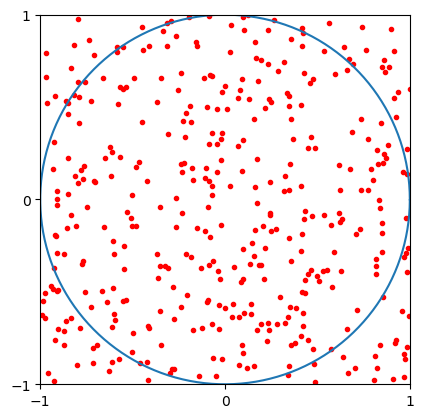

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[98]:14
└ @ Core In[98]:14


In [98]:
using PyPlot, Distributions

# plot circle
phis = range(0, stop=2*pi, step=0.01)
plot(cos.(phis), sin.(phis))

# plot darts
N = 400
d = Uniform(-1, 1)
scatter(rand(d, N), rand(d, N), marker=".", color="r")

# cosmetics
ax = gca()
ax[:set_aspect]("equal")
xlim([-1, 1])
ylim([-1, 1])
xticks([-1, 0, 1])
yticks([-1, 0, 1])
nothing

### Tasks

1. Write a function `compute_pi(N::Int)` which computes $\pi$ by throwing $N$ darts as described above.


2. Based on 1), write a function `compute_pi_parallel(N::Int, nworkers::Int)` which does the same but divides the work among `ncores` processes.


3. Benchmark and compare the methods from 1) and 2).


4. Write a function `compute_pi_multiple(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The function should be serial and based on 1).


5. Write a function `compute_pi_multiple_parallel(Ns::Vector{Int})` which does the same but in parallel. The function should also be based on 1).


6. Benchmark and compare the methods from 4) and 5).


7. Calculate $\pi$ estimates for `Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))`. Plot $\pi$ vs $N$ on a semi-log plot.


8. Bonus: Write a function `compute_pi_multiple_double_parallel(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The calculation should be as parallel as possible. Multiple different values of $N$ should be calculated at the same time and every one of those calculations should be parallel as well.

A reasonable value could be `N = 10_000_000`.

# If time permits....

# SIMD instructions

SIMD stands for "Single Instruction Multiple Data" and falls into the category of instruction level parallelism (vector instructions).

In [ ]:
function mysum(X)
    acc = zero(eltype(X))
    for i in 1:length(X)
        @inbounds acc += X[i]
    end
    return acc
end

Think about if each loop iteration is independent.

Integer addition is **associative** and the order of operations has no impact. Floating-point addition is **non-associative** and the order of operations is important.

By using `@simd`, we are asserting several properties of the loop:

* It is safe to execute iterations in arbitrary or overlapping order, with special consideration for reduction variables.
* Floating-point operations on reduction variables can be reordered, possibly causing different results than without `@simd`.

In [ ]:
function mysum_simd(X)
    acc = zero(eltype(X))
    @simd for i in 1:length(X)
        @inbounds acc += X[i]
    end
    return acc
end

In [ ]:
X = rand(Float64, 1000)
@btime mysum($X);
@btime mysum_simd($X);

In [ ]:
X = rand(Int64, 1000)
@btime mysum($X);
@btime mysum_simd($X);

In [ ]:
X = rand(Float64, 1000)
s = mysum(X);
s_simd = mysum_simd(X);

In [ ]:
s == s_simd # will sometimes be false!!!

In [ ]:
abs(s-s_simd)

# Multi-threading

On Linux/MacOS:

```bash
export JULIA_NUM_THREADS=4
```

On Windows:

```bash
set JULIA_NUM_THREADS=4
```

Afterwards start julia.

*Switching to REPL to demonstrate this...*

```julia
using Base.Threads

# How many threads are we running on?
nthreads()

# How many processes are we running?
using Distributed; nprocs()

# Fill an array in parallel
a = zeros(nthreads()*10)
@threads for i in 1:length(a)
    a[i] = threadid()
end
```

Note that we do not need to use a `SharedArray` or similar here since threads are process shared memory. Although convenient in this example, this fact can potentially lead to *thread safety* and *race condition* issues where different threads access the same piece of memory. Writing fast thread safe code isn't trivial!

See for example the sections [Atomic Operations](https://docs.julialang.org/en/stable/manual/parallel-computing/#Atomic-Operations-1) and [Side effects and mutable function arguments](https://docs.julialang.org/en/stable/manual/parallel-computing/#Side-effects-and-mutable-function-arguments-1) of the Julia documentation.

# MPI.jl

Simple wrapper to the Message Passing Interface (MPI).

Github: https://github.com/JuliaParallel/MPI.jl

Example usage:

```julia
import MPI

MPI.Init()

comm = MPI.COMM_WORLD
MPI.Barrier(comm)

root = 0
r = MPI.Comm_rank(comm)

sr = MPI.Reduce(r, MPI.SUM, root, comm)

if(MPI.Comm_rank(comm) == root)
   @printf("sum of ranks: %s\n", sr)
end

MPI.Finalize()
```

Run as
```
mpirun -np 4 ./julia example.jl
```